# BATADAL - ARMA Task

## 2. Other signals

The BATtle of the Attack Detection ALgorithms (BATADAL) data is the hourly historical supervisory control and data acquisition (SCADA) operations of the C-Town water distribution system ([R. Taormina et al, 2018](http://dx.doi.org/10.1061/%28ASCE%29WR.1943-5452.0000969)).

This notebook is a sub-task for the *ARMA (autoregressive moving average model)* task. The purpose of this sub-task is to learn an ARMA model for four more individual sensors (pick them in a sensible way!). The signals selected for this task are:

- Water level of tank T3, *L_T3* (presented in the other notebook)
- Water level of tank T1, *L_T1*
- Water level of tank T2, *L_T2*
- Pressure at junction J302, *P_J302*
- Flowrate at pump PU2, *F_PU2*

In [19]:
%matplotlib inline
import pandas as pd
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import acf, pacf, ARMA
from statsmodels.tools.eval_measures import rmse

### 2.0 Load the functions
Below we create functions for:
- making autocorrelation plot and partial autocorrelation plot,
- performing grid search for Akike Information Crieteria (AIC) for ARMA models,
- build and fit the ARMA model and make predictions, and
- plot the real vs predict data.

In [2]:
# split data into train and test datasets
def split_train_test(df, n = 24): # n = test size
    train = df[:-n]
    test = df[-n:]
    return train, test

In [3]:
# plot autocorrelation plot and partial autocorrelation plot
def acf_plots(df, lag = 30):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (6, 4))
    
    fig = plot_acf(df, lags = lag, ax = ax1)
    fig = plot_pacf(df, lags = lag, ax = ax2)
    
    ax2.set_xlabel('Lag (hour)')

In [70]:
# perform aic calculations given orders (p, q) and plot the aic grid
def aic_heatmap(df, ps = range(1, 3), qs = range(1, 3), title = 'AIC Grid'):
    aic = [[p, q, ARMA(df, order=(p, q), freq='H').fit().aic]
           for p in ps for q in qs if ((p!=0)|(q!=0))]
    aic = pd.DataFrame(aic, columns = ['p', 'q', 'aic'])
    
    # plot heatmap showing aic values vs (p, q) parameters
    sns.heatmap(aic.pivot('p', 'q', 'aic'), 
                annot = True, fmt='0.1f', linewidths=1)
    plt.title(title)

In [2]:
# train model to predict the next value per time tick
def arma_train_predict(train, test, p, q):
    history = [x for x in train] # set history (=training data)
    predictions = [] # start prediction
    
    # train model and predict the next time tick
    for t in range(len(test)):
        model = ARMA(history, order = (p, q)).fit()
        vPred = model.forecast(steps = 1)[0]
        vReal = test.values[t]
        predictions.append(float(vPred))
        history.append(vReal)
    
    # calculate mean square error
    error = rmse(test.values, np.array(predictions))
    
    return predictions, error

In [14]:
# plot the real vs prediction data
def real_vs_predict(test, predictions, title = 'Variable in interest',
                    ylabel = 'Unit', xlabel = 'Time (hr)'):
    comparison = pd.DataFrame({'original' : test,
                               'predict' : predictions})
    comparison.plot(style = ['b--','r--'])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

### 2.1 Selected signals

### a. Water level of tank T1, *L_T1*

In [2]:
# Load dataset
dftrain1 = pd.read_csv('./data/BATADAL_dataset03.csv')

# Modify string date to timestamp
dftrain1.DATETIME = dftrain1.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))

# Set timestamp as index
dftrain1.set_index('DATETIME', inplace = True)

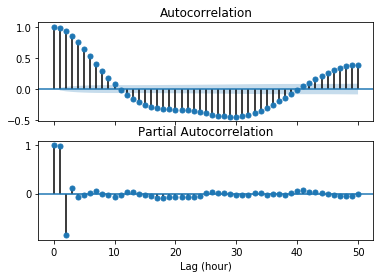

In [41]:
train, test = split_train_test(dftrain1.L_T1, n = 24*3)
acf_plots(train, lag = 50)

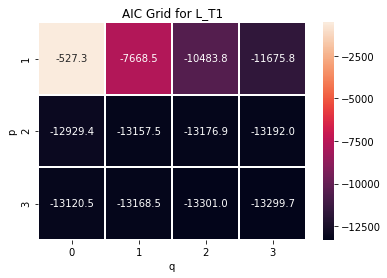

In [25]:
aic_heatmap(train, ps = range(1, 3+1), qs = range(0, 3+1), 
            title = 'AIC Grid for L_T1')

In [26]:
predictions, error = arma_train_predict(train, test, p=2, q=0)

print('ARMA resulting mean square error: %0.3f' % error)

ARMA resulting mean square error: 0.013


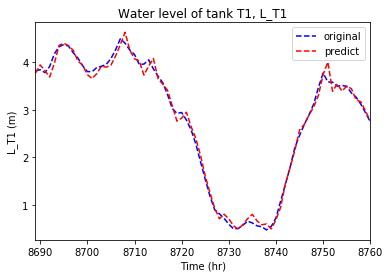

In [27]:
real_vs_predict(test, predictions, 
                title = 'Water level of tank T1, L_T1', 
                ylabel = 'L_T1 (m)')

### b. Water level of tank T2, *L_T2*

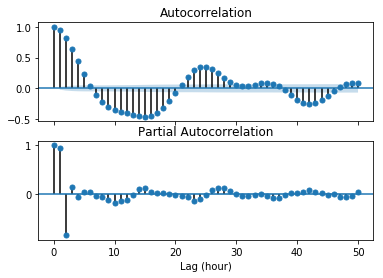

In [45]:
train, test = split_train_test(dftrain1.L_T2, n = 24*3)
acf_plots(train, lag = 50)

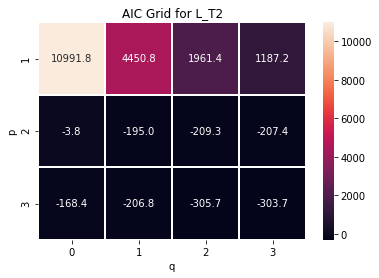

In [30]:
aic_heatmap(train, ps = range(1, 3+1), qs = range(1, 3+1), 
            title = 'AIC Grid for L_T2')

In [31]:
predictions, error = arma_train_predict(train, test, p=2, q=1)

print('ARMA resulting mean square error: %0.3f' % error)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARMA resulting mean square error: 0.049


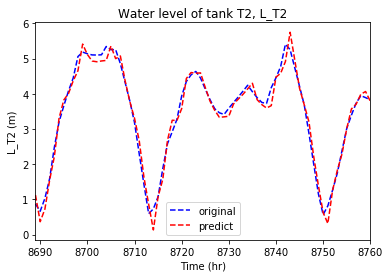

In [32]:
real_vs_predict(test, predictions, 
                title = 'Water level of tank T2, L_T2', 
                ylabel = 'L_T2 (m)')

### c. Pressure at junction J302, *P_J302*
We can also try a differnt length of testing data, e.g., 5 days.

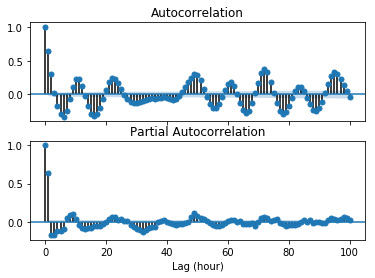

In [76]:
train, test = split_train_test(dftrain1.P_J302, n = 24*5)
acf_plots(train, lag = 100)

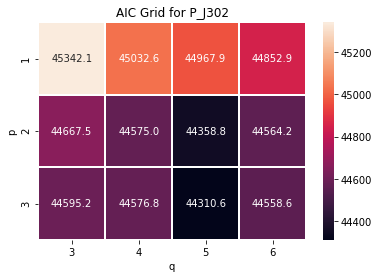

In [77]:
aic_heatmap(train, ps = range(1, 3+1), qs = range(3, 6+1), 
            title = 'AIC Grid for P_J302')

In [78]:
predictions, error = arma_train_predict(train, test, p=2, q=5)

print('ARMA resulting mean square error: %0.3f' % error)

ARMA resulting mean square error: 9.676


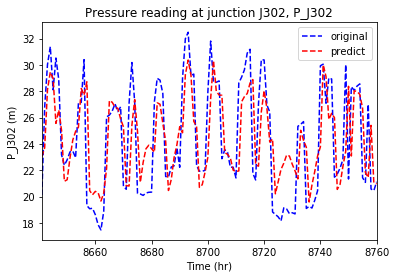

In [79]:
real_vs_predict(test, predictions, 
                title = 'Pressure reading at junction J302, P_J302', 
                ylabel = 'P_J302 (m)')

### d. Flowrate at pump PU2, *F_PU2*

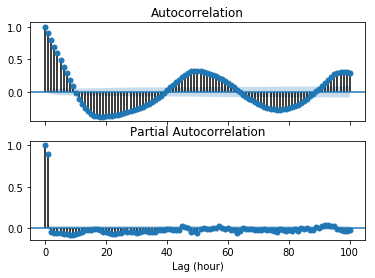

In [80]:
train, test = split_train_test(dftrain1.F_PU2, n = 24*3)
acf_plots(train, lag = 100)

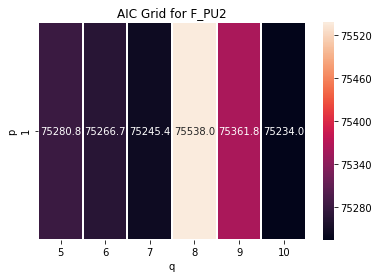

In [65]:
aic_heatmap(train, ps = range(1, 1+1), qs = range(5, 10+1), 
            title = 'AIC Grid for F_PU2')

In [66]:
predictions, error = arma_train_predict(train, test, p=1, q=7)

print('ARMA resulting mean square error: %0.3f' % error)

ARMA resulting mean square error: 242.696


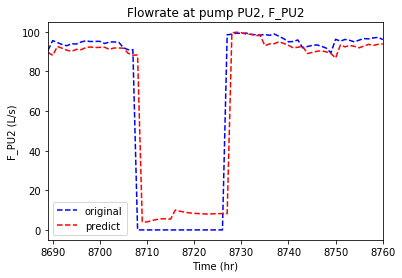

In [67]:
real_vs_predict(test, predictions, 
                title = 'Flowrate at pump PU2, F_PU2', 
                ylabel = 'F_PU2 (L/s)')

### 2.2 Conclusion

From the results we can see that ARMA method **performs better for "continuous" signals such as the water level of tanks**. The method returns larger errors when dealing with more "discretized" signals such as the flowrate of pumps (which is zero when pumps are not activated) and the pressure readings of the junctions.